In [1]:
#already built in with python
import os
import datetime 

#installed with conda-forge
import numpy
import numpy as np
import xarray as xr
import matplotlib as plt
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import Point


#installed with pip 
import pystac
import pystac_client
import rasterio

# **Same visuals, but different on the inside**
----

The new Earth Observation Processing Framework (**EOPF**) Zarr format is changing the way Sentinel products are delivered. The already .SAFE format will no longer exist to be replaced by Zarr data but don't be scared, Sentinel data is the same, just the storage format and delivery is different. Let's take a look...

## **STAC catalog**
------
The STAC catalog, when you can access the data, has the same apearance and organization schema!

| ![Image 1](img/old.png) | ![Image 2](img/zarr.png) |
|---------------------------------|------------------------|
| CDSE - STAC API                 | EOPF Sentinel Zarr Samples Service STAC API              


But, if you notice carefully, there is a small but significant difference: the EOPF Zarr service has Sentinel-1 SLC data, which didn't exist in the old CDSE STAC catalogue. The main reason for this is the the new Zarr format, because it's cloud-native, can handle in a much simpler way, heavier data, such as Sentinel-1 SLC data (*not only contains the backscatter information, but also the phase informtion, which is essential for InSAR, but we'll talk about that later*)

**Access the data using ID** - The way data is presented is the same, even though the way it is stored is not the same. These are great news! If you want to access a specif product, it still follows the same logic and it did for the CDSE - STAC catalog.

Let's follow this example on how to access Sentinel-1 Level-1 GRD data to see how the data is stored on the EOPF Sentinel Zarr Samples Service.

### 1. Source ID for the STAC

<img src="img/source_id_catalogue.png" width="500"/>

In [2]:
stacID = "eopf-sample-service-stac-api"
stacURL = "https://stac.core.eopf.eodc.eu/"

### 2. Source ID for Sentinel-1 Level-1 GRD

<img src="img/source_id_grd.png" width="500"/>

In [3]:
grdID = "sentinel-1-l1-grd"
grdURL = "https://stac.core.eopf.eodc.eu/collections/sentinel-1-l1-grd"

### 3. Source ID for the specific product

<img src="img/source_id_product.png" width="500"/>

In [4]:
productID = "S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD"
productURL = "https://stac.core.eopf.eodc.eu/collections/sentinel-1-l1-grd/items/S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD"

## **But attention** 🚨
---

- If by any chance you try to look for the same product but on the old catalog we'll find basically the same product but with a different identification name. Are those the same products? Why do they have different names?

Let's dive into this problem!


#### **1. ID names of products**
Let's analyse the ID names of Sentinel products!

Each Sentinel product follows a similar structure, having identifiers to distiguish between products. Each product can be seen a "photo" taken by the satellite and, for each photo, the information is stored under this product ID names.

In [5]:
print("Product ID =", productID)

Product ID = S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD


And, because this product belongs to a specif group of products (Sentinel-1 Level-1 GRD but it could be, Sentinel-1 Level-1 SLC or Sentinel-1 Level-2A), it also has a collection ID.

In [6]:
print("Collection ID =", grdID)

Collection ID = sentinel-1-l1-grd


In the end, all the products from all the collections are stored on the same STAC catalog.

In [7]:
print("Catalog ID =", stacID)

Catalog ID = eopf-sample-service-stac-api


------

Now let's breakdown the point product name from the EOPF Sentinel Zarr Samples Service: 

1- ```S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD``` 

and compare it with the same product from the old STAC catalog: 

2- ```S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_E620_COG```

Product from EOPF Sentinel Zarr Samples Service: `S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD`:

| Part                 | Value               | Meaning                                                                |
|----------------------|---------------------|------------------------------------------------------------------------|
| **S1A**              | S1A                 | **Satellite**: Sentinel-1A                                             |
| **IW**               | IW                  | **Acquisition Mode**: Interferometric Wide Swath                       |
| **GRDH**             | GRDH                | **Product Type**: Ground Range Detected (GRD), High resolution         |
| **1SSH**             | 1SDV                | **Product Level and Polarisation**: Level-1, Dual polarization (VV+VH) |
| **20250708T124813**  | 08-07-2025 12:48:13 | **Start Time** (UTC): acquisition start time                           |
| **20250708T124838**  | 08-07-2025 12:48:38 | **Stop Time** (UTC): acquisition end time                              |
| **059992**           | 059992              | **Absolute Orbit Number**: Sequential number representing how many complete orbits the satellite has made since launch. It increases by 1 for each orbit (approx. every 98 minutes)                          |
| **0773EF**           | 0773EF              | **Mission Data Take ID**: It increases each time the sensor is turned on, kind of identifying a "recording session". It is useful to identify if two products were taken on the same continuous acquisition                                                |
| **6FFD**             | 6FFD                | **Unique Identifier / Product ID**: It is unique for each product, similar to an ID number|

-------

Now, let's compare the two products!

`S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD` vs `S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_E620_COG`


|      | EOPF Sentinel Zarr Samples Service | old STAC catalog   |  Is it the same?|   
|--------------------------------------|---------------------|--------------------------------------------------------------|-----|
| **Satellite**                        | S1A                 | S1A                                            |✅|
| **Acquisition Mode**                 | IW                  | IW                       |✅|
| **Product Type**                     | GRDH                | GRDH         |✅|
| **Product Level and Polarisation**   | 1SSH                | 1SSH|✅|
| **Start Time**                       | 08-07-2025 12:48:13 |08-07-2025 12:48:13|✅|
| **Stop Time**                        | 08-07-2025 12:48:38 |08-07-2025 12:48:38|✅|
| **Absolute Orbit Number**            | 059992              | 059992                                              |✅|
| **Mission Data Take ID**             | 0773EF              |0773EF                                               |✅|
| **Unique Identifier**                | 6FFD                | E620                                     |❌|
| **Extra Notation**                | -             | COG                                     |❌|

What does this mean? In fact, these are exactly the same products, just the unique identifier and the extra notation is different. This is because:
- The 6FFD unique identifier shows the original ESA-generated product ID, created when the scene was first processed and the E620 identifier was generated when the file was reprocessed and converted into a COG (Cloud Optimized GeoTIFF).
- This leads us to the extra notation found on the old STAC catalog. The COG suffix	indicates the product was repackaged for cloud/web use and, of course, converted into a COG (Cloud Optimized GeoTIFF). We don't face this situation on the new Zarr format.

## **Navigating on the EOPF Zarr STAC**
---
Starting from the begining, let's navigate through the STAC catalog until we find the dataset and products we want - Sentinel-1 GRD!

In [8]:
import requests
from typing import List, Optional, cast
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
from datetime import datetime

As a starting point, we need to establish the connection with the EOPF Sentinel Zarr Sample Service STAC Catalog. In fact, we already have the URL link for the catalog, as you can see the following print!

In [9]:
print(stacURL)

https://stac.core.eopf.eodc.eu/


With a function called ``Client.open()`` we can see the organizational tree of the catalog itself! We are on the right path! 

In [10]:
eopf_catalog = Client.open(stacURL) 
eopf_catalog

<Client id=eopf-sample-service-stac-api>

In [11]:
print('ID:              ', eopf_catalog.id)
print('Title:           ', eopf_catalog.title)
print('Description:     ', eopf_catalog.description)
print('Links:           ', eopf_catalog.links)

ID:               eopf-sample-service-stac-api
Title:            EOPF Sentinel Zarr Samples Service STAC API
Description:      STAC catalog of the EOPF Sentinel Zarr Samples Service
Links:            [<Link rel=self target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf-sample-service-stac-api>>, <Link rel=data target=https://stac.core.eopf.eodc.eu/collections>, <Link rel=conformance target=https://stac.core.eopf.eodc.eu/conformance>, <Link rel=search target=https://stac.core.eopf.eodc.eu/search>, <Link rel=search target=https://stac.core.eopf.eodc.eu/search>, <Link rel=http://www.opengis.net/def/rel/ogc/1.0/queryables target=https://stac.core.eopf.eodc.eu/queryables>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-slstr-l1-rbt>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-olci-l2-lfr>, <Link rel=child target=https://s

Now that the catalog connection was established we can take a look at all the collections available at the STAC catalog and, hopefully, find the Sentinel-1 GRD! To do so we'll use a function called ``get_all_collections()``, which will list all the collections available on the catalog.

Because the STAC catalog is still under development, not all the collections under the catalog are valid. To avoid getting a long error message we print the collections ID this way, showing only the collections valid and active!

In [12]:
try:
    for collections in eopf_catalog.get_all_collections():
        print(collections.id)
except Exception:
    print(
        "* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 where you can check the progress of this issue]"
    )

sentinel-2-l2a
sentinel-3-slstr-l1-rbt
sentinel-3-olci-l2-lfr
sentinel-2-l1c
sentinel-3-slstr-l2-lst
sentinel-1-l1-slc
sentinel-3-olci-l1-efr
sentinel-3-olci-l1-err
sentinel-1-l2-ocn
sentinel-1-l1-grd
* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 where you can check the progress of this issue]


Taking a close look we see that Sentinel-1 GRD collection is active and it matches the ID name we store in the beggining.

In [13]:
print("Our collection ID as we stored it before:", grdID)

try:
    for collections in eopf_catalog.get_all_collections():
        if collections.id == grdID:
            print("It's a match!")
except Exception:
    print()

Our collection ID as we stored it before: sentinel-1-l1-grd
It's a match!



Similar to function used before, we'll use the ``get_collection()``function, since we already know the ID of the collection we want to access. After this we'll be able to get more useful information about Sentinel-1 GRD collection! **We are already inside the Sentinel-1 GRD catalog**, now it's time to start looking for useful and meaningful products we can work with.

In [14]:
s1grd = eopf_catalog.get_collection(grdID)
s1grd

<CollectionClient id=sentinel-1-l1-grd>

In [15]:
print('ID:              ', s1grd.id)
print('Title:           ', s1grd.title)
print('Description:     ', s1grd.description)
print('License:         ', s1grd.license)
print('Keywords:        ', s1grd.keywords)
print('Providers:       ', s1grd.providers)
print('Extent:          ', s1grd.extent)
print('Links:           ', s1grd.links)
print('Assets:          ', s1grd.assets)

ID:               sentinel-1-l1-grd
Title:            Sentinel-1 Level-1 GRD
Description:      The Sentinel-1 Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using the Earth ellipsoid model WGS84. The ellipsoid projection of the GRD products is corrected using the terrain height specified in the product general annotation. The terrain height used varies in azimuth and it is constant in range (For IW/EW modes only the terrain height of first subswath is considered)
License:          proprietary
Keywords:         ['Copernicus', 'Sentinel', 'EU', 'ESA', 'Satellite', 'SAR', 'C-Band', 'GRD']
Providers:        [<pystac.provider.Provider object at 0x14b38dfd0>, <pystac.provider.Provider object at 0x14b38c360>, <pystac.provider.Provider object at 0x14b38e040>]
Extent:           <pystac.collection.Extent object at 0x14b375090>
Links:            [<Link rel=items target=https://stac.core.eopf.eodc.eu/colle

##### **summarizing**:
- ``Client.open()``: to access the catalog;
- ``get_all_collections()``: to check all the collection available on the catalog;
- ``get_collection()``: to get a specif collection we want to work with;

## **Searching and filtering inside a EOPF Zarr STAC collection**
---
The next step is to search and look for products inside the collection we chose!

One of the most basic functions we'll use, and probably one of the most important ones is the ``.search()``function. It will allow us to search and filter for collections and products inside a catalog.

We can filter the search on the catalog by using the following elements:
1. **Collections**: using `collections =`, it filters the catalog by the collections, choosing the searching names like **'sentinel-2-l2a'**, **'sentinel-1-l1-grd'** or **'sentinel-1-l1-slc'**;
2. **Date and Time**: using `datetime =`, it filters the catalog by the time interval in which the products can be found. The search should follow this format: **'2020-05-01T00:00:00Z/2025-05-31T23:59:59.999999Z'**, but if you want you can also exclude the time part;
3. **Area of Interest**: using `bbox = ()` and inserting the lat and long values for the top left corner and bottom right corner of the AOI;
4. **IDs**: using `ids =`, it filters the catalog by the source ID of the product, returning only the product matching that ID;

The following function, ``list_found_elements``is pretty useful for the next few steps because it will help us construct a list from any search result we might get.

In [16]:
def list_found_elements(search_result):
    ids = []
    coll = []
    for item in search_result.items(): 
        ids.append(item.id)
        coll.append(item.collection_id)
    return ids , coll

- Search by collection and datetime

In [17]:
search_catalog_collection_datetime = eopf_catalog.search(
    collections = 'sentinel-1-l1-grd', #sentinel-1 GRD collection
    datetime = "2025-07-01T00:00:00Z/2025-07-01T00:15:01Z" #15 minutes of acquisition on 01 July 2025
) 

print("This is how our search literally looks: ", search_catalog_collection_datetime)

collection_datetime_items = list_found_elements(search_catalog_collection_datetime)
print("Found", len(collection_datetime_items[0]), "products on this search.")
print(collection_datetime_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x14aa4f380>
Found 4 products on this search.
['S1A_IW_GRDH_1SDV_20250701T001438_20250701T001503_059883_077026_5239', 'S1A_IW_GRDH_1SDV_20250701T001413_20250701T001438_059883_077026_7438', 'S1A_IW_GRDH_1SDV_20250701T001348_20250701T001413_059883_077026_15F7', 'S1A_IW_GRDH_1SDV_20250701T001319_20250701T001348_059883_077026_3624']


- Search by ID

In [18]:
search_catalog_ID = eopf_catalog.search(
    ids = 'S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58' 
)

print("This is how our search literally looks: ", search_catalog_ID)

ID_items = list_found_elements(search_catalog_ID)
print("Found", len(ID_items[0]), "product on this search.")
print(ID_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x14aa46e90>
Found 1 product on this search.
['S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58']


- Search collection, datetime and area of interest

In [19]:
search_catalog_all = eopf_catalog.search(
    collections = 'sentinel-1-l1-grd', #sentinel-1 GRD collection
    datetime = "2025-07-06T00:00:00Z/2025-07-07T23:59:59Z", #acquisitions on the 06 July 2025 and 07 July 2025
    bbox=(-9.283880, 38.634131, #top left corner of AOI
          -8.964918, 38.810976) #bottom right corner of AOI
) 

print("This is how our search literally looks: ", search_catalog_all)

time_items = list_found_elements(search_catalog_all)
print("Found", len(time_items[0]), "products on this search.")
print(time_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x14aa46710>
Found 3 products on this search.
['S1A_IW_GRDH_1SDV_20250707T063514_20250707T063539_059974_077342_34A8', 'S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58', 'S1C_IW_GRDH_1SDV_20250706T064218_20250706T064243_003096_006487_0E3A']


Finally, we need to actually access the items that we've been filtering on the STAC catalog. To do that we need to get their storage location in the cloud, getting its URL link, something similar to his one: `https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr`.

To do so

In [20]:
product_id = ID_items[0][0] #[0][0] ids and columns, it would print the id of the product we want

item = s1grd.get_item(product_id) #basically looking for the product with ID we wanted on a specific catalog

zarr_assets = item.get_assets(media_type=MediaType.ZARR)

assets_loc = [zarr_assets]
the_item = assets_loc[0]

print('URL for accessing', product_id, 'item:  ', the_item['product'].href)


URL for accessing S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58 item:   https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr


Inside the .zarr asset we got we have the following metadata, which corresponds exactly to the assets found on the STAC API 

In [21]:
print(list(the_item.keys()))

['vh', 'vv', 'product', 'noise-vh', 'noise-vv', 'calibration-vh', 'calibration-vv']


<img src="img/metadata.png" width="400"/>


##### **summarizing**:
- ``.search()``: filtering elements inside a catalog;
- ``list_found_elements()``: to list the elements found with the search parameters;
- ``.get_item()``: gets the product with that ID froma. specific catalog;
- ``.get_assets(media_type=MediaType.ZARR)``: get the URL .zarr from the assets stored;
- ``.keys()``: get the URL .zarr from the assets stored;

## **Discovering the groups and sub grouops inside a Zarr product**
----
Now that we've found a specific product we want to work with, let's try to understand how everything is structured inside of it. We'll work with this product: `S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58`!

The new Zarr format stores Sentinel data in four different groups. It is important to understand this structure because later, when we'll need to access the data, we'll need to know where to find it.

The EOPF Zarr Sentinel structure contains four main groups:
- **Attributes**: STAC format metadata of the imagery, such as chunking information (how the data is divided into the several chunks) and product specific metadata (like acquisition time or sensor specifics);
- **Measurements**: Main retrieved variables, such as reflectance (for Sentinel-1 GRD) and phase information (for Sentinel-1 SLC) or the several band information (when talking about Sentinel-2);
- **Conditions**: Geometric angles, meteorological and instrumental data or any other information concerning;
- **Quality**: Quality information concerning the measurements and masks;

-----

To start accessing and exploring the data we'll need the following libraries:

In [22]:
import os
import xarray as xr

In [23]:
eopf_catalog #the catalog we created the connection with

<Client id=eopf-sample-service-stac-api>

In [24]:
s1grd #the collection we are working on

<CollectionClient id=sentinel-1-l1-grd>

We'll be working the product we lready filtered: ``S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58`` and the correspondent URL for the assets!

In [25]:
zarr_product_URL = the_item['product'].href

print("These are the asstes we can access:", the_item.keys())
print("This is the URL for the .zarr product:", zarr_product_URL)
print("Or for example, this would be the URL for the .zarr VV product:", the_item['vv'].href)

These are the asstes we can access: dict_keys(['vh', 'vv', 'product', 'noise-vh', 'noise-vv', 'calibration-vh', 'calibration-vv'])
This is the URL for the .zarr product: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr
Or for example, this would be the URL for the .zarr VV product: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VV/measurements


We'll use some funtions from the ``xarray``library. 

The ``open_datatree()`` function allows us to open hierarchical datasets, which is a fancy way to say that our dataset is structured in folders (in our case called groups) and subfolders (or subgroups) - exactly the Zarr format situation. So, in conclusion, using this function will allow us to **load the entire structure of groups and subgroups into accessible objects, where we can navigate, inspect and extract data from any level**.

On the other hand, if we prefer to **open just one group at a time** (intead of unfolding the whole dataset tree), we can use ``open_dataset()``funtion and proceed with the same inspection.

In [26]:
sample_tree = xr.open_datatree(zarr_product_URL,
    engine = "zarr", 
    chunks={}
                              )

#xr.open_datatree(zarr_product_URL, engine = "zarr", chunks={})
print(sample_tree)

<xarray.DataTree>
Group: /
│   Attributes:
│       other_metadata:  {'azimuth_steering_rate': 0.0, 'eopf_category': 'eoconta...
│       stac_discovery:  {'assets': {}, 'bbox': [-7.846913, 37.906101, -11.140997...
├── Group: /S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH
│   │   Attributes:
│   │       other_metadata:  {'azimuth_steering_rate': 0.0, 'downlink_information': {...
│   │       stac_discovery:  {'assets': {}, 'bbox': [-7.846913, 37.906101, -11.140997...
│   ├── Group: /S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions
│   │   ├── Group: /S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/antenna_pattern
│   │   │       Dimensions:           (azimuth_time: 27, slant_range_time: 693)
│   │   │       Coordinates:
│   │   │         * azimuth_time      (azimuth_time) datetime64[ns] 216B 2025-07-06T18:35:39....
│   │   │           slant_range_time  (azimuth_time, slant_range_time) float64 150kB dask.array<chunksize=(27, 693), meta=np.ndarray>
│   │   │ 

In [27]:
sample_set = xr.open_dataset(zarr_product_URL,
    engine = "zarr", 
    chunks={},
    group = "/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements"
                            )

#xr.open_dataset(zarr_product_URL, engine = "zarr", chunks={}, group = "/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements")
print(sample_set)

<xarray.Dataset> Size: 868MB
Dimensions:       (azimuth_time: 16695, ground_range: 26006)
Coordinates:
  * azimuth_time  (azimuth_time) uint16 33kB 19608 9752 65432 ... 61727 51872
Dimensions without coordinates: ground_range
Data variables:
    grd           (azimuth_time, ground_range) uint16 868MB dask.array<chunksize=(5161, 26006), meta=np.ndarray>


In [28]:
for i in sorted(sample_tree.groups):
    print(i)

/
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/antenna_pattern
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/attitude
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/azimuth_fm_rate
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/coordinate_conversion
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/doppler_centroid
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/gcp
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/orbit
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/reference_replica
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/replica
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/terrain_height
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/quali

**the following doesn't print anything because it's not loading anything and the group is empty**

**ITS PRINTING NOW**

In [29]:
for i in sorted(sample_set):
    print(i)

grd


In [30]:
import zarr
zarr_store = zarr.open(zarr_product_URL, mode='r')
print(zarr_store.tree())

/


In [31]:
measurements_groups = []
for i in sorted(sample_tree.groups):
    if "measurements" in i:
        measurements_groups.append(i)
print(measurements_groups)

['/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements', '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VV/measurements']


In [32]:
sample_tree.groups[1]

'/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH'

In [33]:
sample_tree[sample_tree.groups[1]].groups

('/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/quality',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/antenna_pattern',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/attitude',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/azimuth_fm_rate',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/coordinate_conversion',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/doppler_centroid',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/gcp',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/orbit',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/reference_replica',
 '/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/replica',
 '/S01SIWGRD_20250706T183

In [34]:
#xr.open_dataset(zarr_product_URL, engine = "zarr", chunks={}, group = "/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements")
grd = sample_tree[sample_tree.groups[1]]["measurements/grd"]
print(grd)

<xarray.DataArray 'grd' (azimuth_time: 16695, ground_range: 26006)> Size: 868MB
dask.array<open_dataset-grd, shape=(16695, 26006), dtype=uint16, chunksize=(5161, 26006), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) uint16 33kB 19608 9752 65432 ... 61727 51872
Dimensions without coordinates: ground_range
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time'], 'dimensions': ['azimuth_t...
    dtype:        <u2
    long_name:    measurement data set for GRD IW


In [35]:
import geopandas as gpd

# Create a GeoDataFrame from the feature
gdf = gpd.GeoDataFrame.from_features(
    [
        {
            "type": "Feature",
            "geometry": sample_tree.attrs["stac_discovery"][
                "geometry"
            ],  # Use the actual geometry, not the bbox
            "properties": sample_tree.attrs["stac_discovery"][
                "properties"
            ],  # Include all properties
        }
    ],
    crs="EPSG:4326",  # Set the CRS explicitly (adjust EPSG code if needed)
)
gdf.explore()

In [36]:
grd_decimated = grd.isel(azimuth_time=slice(None, None, 5), ground_range=slice(None, None, 5))

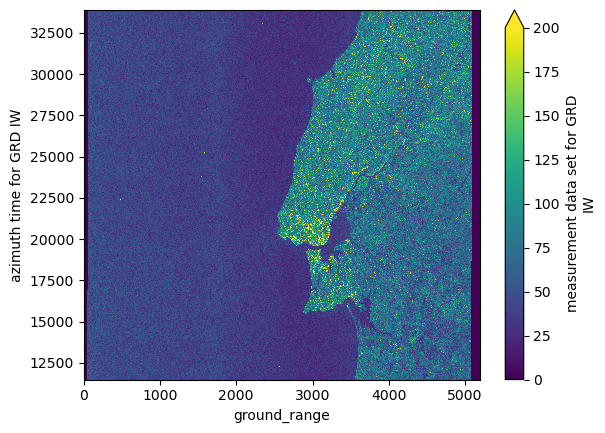

In [37]:
grd_decimated.plot.imshow(vmax=200)
plt.show()

In [38]:
gcp = sample_tree[sample_tree.groups[1]]["conditions/gcp"].to_dataset()
print(gcp)

<xarray.Dataset> Size: 13kB
Dimensions:           (azimuth_time: 210)
Coordinates:
  * azimuth_time      (azimuth_time) datetime64[ns] 2kB 2025-07-06T18:35:38.8...
    line              (azimuth_time) uint32 840B dask.array<chunksize=(210,), meta=np.ndarray>
Data variables:
    elevation_angle   (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    height            (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    incidence_angle   (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    latitude          (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    longitude         (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    pixel             (azimuth_time) uint32 840B dask.array<chunksize=(210,), meta=np.ndarray>
    slant_range_time  (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>


In [39]:
#gcp_iterpolated = gcp.interp_like(grd_decimated)
#gcp_reindexed = gcp.reindex_like(grd_decimated, method="nearest")



base_time = np.datetime64("2025-07-06T18:35:38")  # Example — replace with your actual scene start time
grd_decimated["azimuth_time"] = base_time + grd_decimated["azimuth_time"].astype("timedelta64[ms]")
gcp_reindexed = gcp.reindex_like(grd_decimated, method="nearest")
print(gcp_reindexed)

<xarray.Dataset> Size: 214kB
Dimensions:           (azimuth_time: 3339)
Coordinates:
  * azimuth_time      (azimuth_time) datetime64[ms] 27kB 2025-07-06T18:35:57....
    line              (azimuth_time) uint32 13kB dask.array<chunksize=(210,), meta=np.ndarray>
Data variables:
    elevation_angle   (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>
    height            (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>
    incidence_angle   (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>
    latitude          (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>
    longitude         (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>
    pixel             (azimuth_time) uint32 13kB dask.array<chunksize=(210,), meta=np.ndarray>
    slant_range_time  (azimuth_time) float64 27kB dask.array<chunksize=(210,), meta=np.ndarray>


In [40]:
grd_decimated = grd_decimated.assign_coords(
    {"latitude": gcp_reindexed.latitude, "longitude": gcp_reindexed.longitude}
)

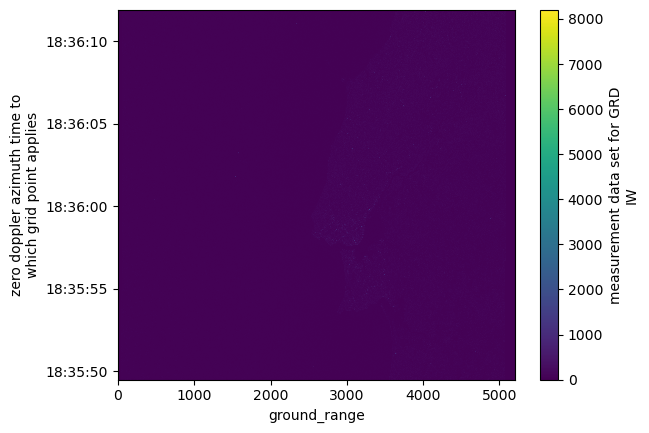

In [41]:
grd_decimated.plot.imshow()
plt.show()